# Modeling dispersive material 
- Show how to include simple analytical dispersion relations in FDTD, illustrated by an example of simulating surface plasmon polaritonic (SPP) resonance between gold and air interface.
- Introduction to a popular method for describing material dispersion in FDTD, known as the complex-conjugate pole-residue method.
- Show how to include more complicated dispersion relations that need to be inferred from tabulated data, illustrated by an example of simulating crystalline silicon slab transmission with the help of dispersion fitting tools.

## surface plasmon polariton resonance

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web
from tidy3d.constants import C_0, HBAR

In [2]:
# Drude parameters for gold
eps_inf = 9.84 # relative permittivity at infinite frequency
wp = 9.01 #eV, plasma frequency
gamma = 0.072 #eV, damping rate

# Unit conversion from ev to Hz
wp_hz = wp / HBAR / 2 / np.pi
gamma_hz = gamma / HBAR / 2 / np.pi

# Tidy3d Drude model
mat_gold = td.Drude(eps_inf = eps_inf, coeffs = [(wp_hz,gamma_hz)], name='gold Drude')

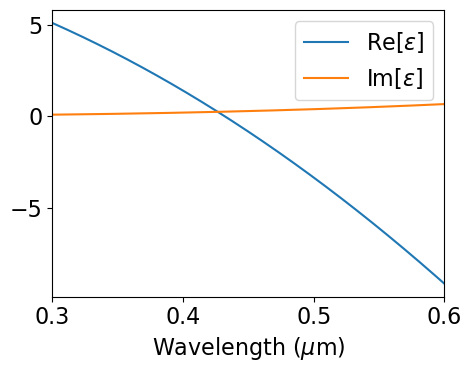

In [3]:
# Compute permittivity in a range of wavelengths
lambda_list = np.linspace(0.3,0.6,500) # um
freq_list = C_0/lambda_list
ep = mat_gold.eps_model(freq_list)

# Visualize the real and imaginary part of permittivity
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,tight_layout=True,figsize=(5,4))
ax.plot(lambda_list,ep.real,label="Re[$\epsilon$]")
ax.plot(lambda_list,ep.imag,label="Im[$\epsilon$]")
ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_xlim(lambda_list[0],lambda_list[-1])
ax.legend()
plt.show()

In [4]:
# thickness of gold slab and air space
t_gold = 0.5 #um
t_air = 4 #um

# diple source position
distance = 0.02 #um, distance between the dipole source and the gold-air interface
px = 1 # um, distance between the dipole source and the left boundary of the simulation domain

# simulation size
Lx = 10 #um. we'll be looking at SPP propagating along x-direction, so let's make it long along x-axis
Ly = 2 #um
Lz = t_gold+t_air
sim_size = Lx, Ly, Lz

# Wavelength and frequency range of the source
lambda_range = (0.4,0.6)
lambda0 = (lambda_range[0] + lambda_range[1])/2
freq0 = C_0/lambda0
freqw  = 0.3*(C_0/lambda_range[0]-C_0/lambda_range[1])

# runtime
runtime = 10
t_stop = runtime/freqw

# frequencies and wavelengths of field monitor
# we consider two representative wavelengths: 0.45 um for mirror-like response, and 0.55 um for SPP response
monitor_lambdas = np.array([0.45,0.55]) #um
monitor_freqs = C_0 / monitor_lambdas

In [5]:
# gold slab
gold_slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, -Lz),
        size=(td.inf,td.inf,Lz+2*t_gold),
    ),
    medium=mat_gold,
    name='gold slab',
)

# dipole source
source = td.PointDipole(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    center=(-Lx/2+px, 0, -Lz/2+t_gold+distance),
    polarization='Ex',
    name='dipole',
)

# field monitor
monitor = td.FieldMonitor(
    center = (0, 0, 0),
    size = (Lx, 0, Lz),
    freqs = np.sort(monitor_freqs),
    name='field',
)

# nonuniform mesh
grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
)

In [6]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = grid_spec,
    structures = [gold_slab],
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML()),
)

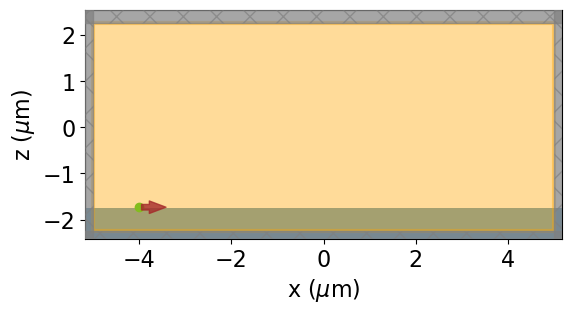

In [7]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(6, 4))
sim.plot(y=0, freq=freq0, ax=ax);
ax.set_title('')
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('z ($\mu$m)')
plt.show()

In [8]:
sim_data = web.run(sim, task_name='lecture05_gold_SPP', path=f'data/data_gold_spp.hdf5')

23:47:16 +07 Created task 'lecture05_gold_SPP' with task_id                     
             'fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=906127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=276747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\taskId]8;;\]8;id=906127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\=]8;;\]8;id=919782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\fdve]8;;\]8;id=906127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\-d0f84264-b69]8;;\
             ]8;id=906127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\e-4ee9-a93c-bcb835094b48']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:47:19 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:47:22 +07 status = preprocess

23:47:24 +07 Maximum FlexCredit cost: 0.063. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

23:47:32 +07 early shutoff detected at 68%, exiting.

23:47:33 +07 status = postprocess

23:47:36 +07 status = success

             View simulation result at                                          
             ]8;id=274015;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=814251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\taskId]8;;\]8;id=274015;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\=]8;;\]8;id=249850;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\fdve]8;;\]8;id=274015;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\-d0f84264-b69]8;;\
             ]8;id=274015;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0f84264-b69e-4ee9-a93c-bcb835094b48\e-4ee9-a93c-bcb835094b48']8;;\.

23:49:08 +07 loading simulation from data/data_gold_spp.hdf5

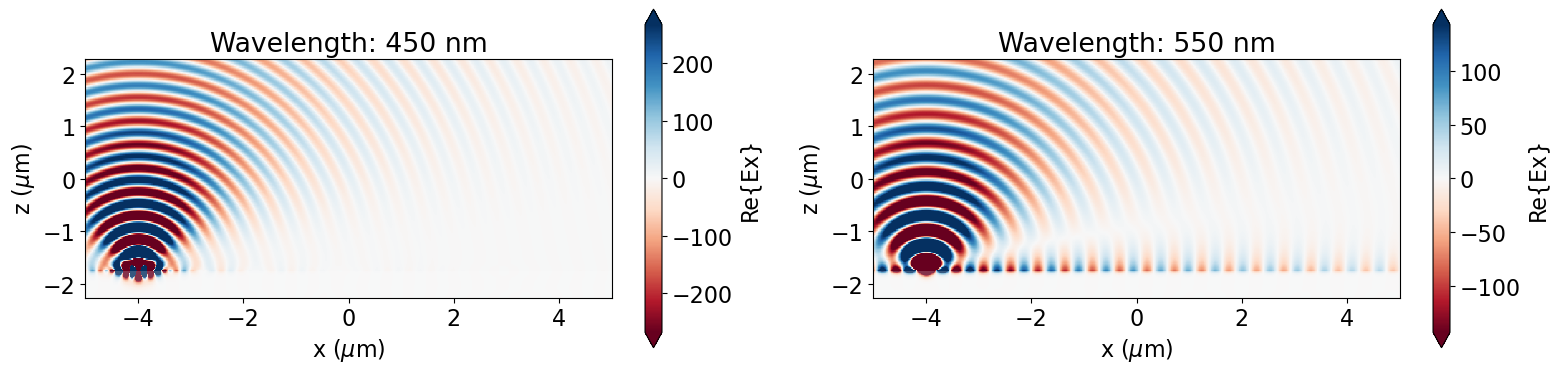

In [9]:
fig, ax = plt.subplots(1,2,figsize=(16, 4), tight_layout=True)

sim_data.plot_field('field', 'Ex', y=0, f=C_0/0.45, val='real', ax = ax[0], vmax = None)
ax[0].set_title('Wavelength: 450 nm')
ax[0].set_xlabel('x ($\mu$m)')
ax[0].set_ylabel('z ($\mu$m)')

sim_data.plot_field('field', 'Ex', y=0, f=C_0/0.55, val='real', ax = ax[1], vmax = None)
ax[1].set_title('Wavelength: 550 nm')
ax[1].set_xlabel('x ($\mu$m)')
ax[1].set_ylabel('z ($\mu$m)')
plt.show()